## GAAIMS: Predicting Multiple Sclerosis from Dynamics of Gait Variability Using an Instrumented Treadmill - A Machine Learning-Based Approach

## Multiple Regression-based scaling of features where regression is done on a separate set of controls for trial W only
#### NOTE: For computing the regression coefficients, we use only Trial 1 data and we aggregate features via means to regress with physical characterstics of person as independent variables.

### Package imports

In [4]:
import numpy as np
import pandas as pd
import math 
import os
import copy
import itertools
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import statsmodels.formula.api as sm
import statsmodels.api as smapi
from RegscorePy import aic
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import csv

In [5]:
path = 'C:\\Users\\Rachneet Kaur\\Dropbox\\GAIT\\control_data\\Treadmill_Data_Controls\\Treadmill_Data_Controls\\'

In [6]:
#Reading the raw dataframe and trial 1 dataframe to compute the regression coefficients 
raw_df = pd.read_csv(path+'..\\..\\extracted_features\\gait_features_30controlsTrialW.csv', index_col = 0)
print ('Full dataframe shape: ', raw_df.shape)

#Reading the demographics of the subjects
demographies = []
demo_file = open(path + '..\\..\\DTC_GS_v3.txt') #File with demographics 
demo = csv.reader(demo_file, delimiter='\t')
for row in demo:
    demographies.append(list(map(float, row[:7]))) 
    #<Columns: SubjectID, Gender (0: Female, 1: Male), -, Height, Weight, _, Age>
demographies = pd.DataFrame(demographies).drop_duplicates().drop([2, 5], axis = 1)
demographies.columns = ['subject ID', 'Gender (0: Female, 1: Male)', 'height (m)','weight (kg)','age (yrs)']
demographies['weight (kg)']/=10 #Converting weight to kg

#Keeping demographics of only the 30 subjects we have the raw data for 
demographies = demographies[demographies['subject ID'].isin(raw_df['PID'].unique())]
demographies.drop(demographies.index[1], axis =0, inplace = True)

#Keeping only the required demographic features
demographies = demographies.set_index('subject ID')

print (demographies.shape)

Full dataframe shape:  (4011, 31)
(30, 4)


In [16]:
print ('Mean:\n', demographies.mean())
print ('\nSD:\n', demographies.std())
print ('\nMin:\n', demographies.min(), '\nMax:\n', demographies.max())
print (demographies['Gender (0: Female, 1: Male)'].value_counts())

Mean:
 Gender (0: Female, 1: Male)     0.300000
height (m)                      1.682333
weight (kg)                    71.611333
age (yrs)                      67.600000
dtype: float64

SD:
 Gender (0: Female, 1: Male)     0.466092
height (m)                      0.171538
weight (kg)                    14.515445
age (yrs)                      10.344414
dtype: float64

Min:
 Gender (0: Female, 1: Male)     0.00
height (m)                      1.01
weight (kg)                    52.97
age (yrs)                      50.00
dtype: float64 
Max:
 Gender (0: Female, 1: Male)      1.00
height (m)                       1.96
weight (kg)                    103.00
age (yrs)                       87.00
dtype: float64
0.0    21
1.0     9
Name: Gender (0: Female, 1: Male), dtype: int64


### 20 controls and 20 PwMS trial W/WT data to scale based on coefficients derived from separate dataset of 30 controls trial W

In [251]:
#Gait features for the subjects to be used for analysis
raw_df2 = pd.read_csv(path + '..\\..\\..\\gait_features.csv', index_col = 0)
raw_df2.dropna(inplace=True)

#Reading the demographics of the real subjects for analysis
demographies2 = pd.read_csv(path + '..\\..\\..\\sample_data\\demographics.csv')

#Keeping demographics of only the 35 subjects we have the raw data for 
demographies2 = demographies2[demographies2['subject ID'].isin(raw_df2['PID'].unique())]

#Keeping only the required demographic features
demographies2 = demographies2[['subject ID', 'height (m)', 'weight (kg)', 'gender (1-female, 2-male)', 'age (yrs)']]
demographies2 = demographies2.set_index('subject ID')

print (raw_df2.shape, demographies2.shape)

(3230, 33) (35, 4)


### Dropping the missing values

In [252]:
#Dropping the NaN containing columns 
raw_df.dropna(inplace=True)

features = ['PID', 'stride_time', 'stance_time', 'swing_time', 'SS_R', 'DS_L', 'DS_R', 'stride_length', 'stride_width',
       'cadence', 'stride_speed',  'walk_ratio', 'force_HSR', 'force_TOL', 'force_MidSSR',
       'force_HSL', 'force_TOR', 'force_MidSSL']
stat_features = features+['LeftFPA', 'RightFPA', 'Butterfly_x_abs', 'ButterflySQ_x']
raw_df=raw_df[stat_features]

print ('Full dataframe shape: ', raw_df.shape)

Full dataframe shape:  (3923, 22)


In [253]:
#For computing the regression coefficients, we use only Trial 1 data and
#we aggregate features via means to regress with physical characterstics of person as independent variables.
raw_df = raw_df.groupby(['PID']).mean()

#Sort the values for features to make sure we match the subjects by ID
raw_df.sort_values('PID', inplace=True)

In [254]:
raw_df.head()

,stride_time,stance_time,swing_time,SS_R,DS_L,DS_R,stride_length,stride_width,cadence,stride_speed,...,force_HSR,force_TOL,force_MidSSR,force_HSL,force_TOR,force_MidSSL,LeftFPA,RightFPA,Butterfly_x_abs,ButterflySQ_x
PID,,,,,,,,,,,,,,,,,,,,,
102,1.344101,0.907059,0.437042,0.453210,0.219143,0.234706,1.314343,0.136730,89.898582,0.977754,...,895.159611,879.439441,794.206454,887.933336,908.385405,784.118744,0.537527,0.849989,0.007634,0.000090
104,1.366788,0.931535,0.435253,0.417091,0.264202,0.250242,0.880055,0.137815,87.987976,0.644481,...,760.780322,773.865853,748.168398,774.781255,773.177286,748.244960,1.425461,0.824362,0.006681,0.000062
105,0.946119,0.627238,0.318881,0.324524,0.147452,0.155262,1.293181,0.159439,126.890391,1.367557,...,595.575749,557.791959,404.426186,593.878461,565.909642,396.768610,0.952252,0.311234,0.005047,0.000045
107,1.185467,0.801750,0.383717,0.374117,0.215967,0.211667,1.305486,0.148967,101.372010,1.104128,...,1158.000141,999.706236,920.299814,1107.009907,1007.683192,888.747349,1.084747,0.836310,0.006492,0.000073
109,0.941146,0.625024,0.316122,0.306659,0.162537,0.155829,1.260584,0.177215,127.889529,1.345666,...,1065.553503,1115.800847,763.383612,1075.465922,1121.244483,765.629270,0.818530,0.438725,0.006000,0.000070


### VIF for physical characteristics to examine multicollinearity between them

In [255]:
X = add_constant(demographies)
VIF = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
print ('VIF values: ', VIF)
#Since all the VIF values<5, hence, we use all the physical factors as independent variables in multiple regression 

VIF values:  const                          452.853963
Gender (0: Female, 1: Male)      2.356415
height (m)                       2.012432
weight (kg)                      2.056829
age (yrs)                        1.649474
dtype: float64


### Correlation among the physical characteristics of the subjects (to be used as independent variables for linear regression)

In [256]:
demo_features = ['weight (kg)', 'age (yrs)', 'height (m)']
print (demographies[demo_features].corr('spearman'))
print (stats.spearmanr(demographies[demo_features]))
demographies[demo_features].corr('spearman')

             weight (kg)  age (yrs)  height (m)
weight (kg)     1.000000  -0.535599    0.456398
age (yrs)      -0.535599   1.000000   -0.364154
height (m)      0.456398  -0.364154    1.000000
SpearmanrResult(correlation=array([[ 1.        , -0.53559945,  0.45639849],
       [-0.53559945,  1.        , -0.3641535 ],
       [ 0.45639849, -0.3641535 ,  1.        ]]), pvalue=array([[0.        , 0.00228694, 0.01124257],
       [0.00228694, 0.        , 0.04789265],
       [0.01124257, 0.04789265, 0.        ]]))


,weight (kg),age (yrs),height (m)
weight (kg),1.000000,-0.535599,0.456398
age (yrs),-0.535599,1.000000,-0.364154
height (m),0.456398,-0.364154,1.000000


In [257]:
#Point Biserial correlation coefficient is used to examine correlation between a categorical and a numerical variable 
#For gender since it is a categorical variable 
corr_with_gender = []
for feat in demo_features:
    corr_with_gender.append(stats.pointbiserialr(demographies['Gender (0: Female, 1: Male)'], demographies[feat]))
print (corr_with_gender)

[PointbiserialrResult(correlation=0.5448921827074423, pvalue=0.0018486105665315008), PointbiserialrResult(correlation=-0.08868425604008276, pvalue=0.6411984897408496), PointbiserialrResult(correlation=0.6465039082071554, pvalue=0.00011345910603372089)]


### Multiple regression using backward elimination with p = 0.1 as cutoff and AIC criterion for evaluation

In [258]:
#Since gender is a categorical variable, we create one hot encoding of the same before applying regression models
demographies['Gender (0: Female, 1: Male)'] = demographies['Gender (0: Female, 1: Male)'].astype(object)
demographies_x = pd.get_dummies(demographies)
demographies_x = add_constant(demographies_x)
#Sort the values by subject ID to make sure we regress on the subjects correctly 
demographies_x.sort_values('subject ID', inplace=True)

#Separating male and female 
# demographies_x_m = demographies_x[demographies_x['gender (1-female, 2-male)']==2]
# demographies_x_m.drop('gender (1-female, 2-male)', axis = 1, inplace = True)
# demographies_x_f = demographies_x[demographies_x['gender (1-female, 2-male)']==1]
# demographies_x_f.drop('gender (1-female, 2-male)', axis = 1, inplace = True)
# #For males, demographies_x_m; for females, demographies_x_f
# demographies_x_m

In [259]:
#Separating male/females in gait features
# raw_df_trial1_m = raw_df_trial1[demographies_x['gender (1-female, 2-male)']==2]
# raw_df_trial1_f = raw_df_trial1[demographies_x['gender (1-female, 2-male)']==1]

In [260]:
#Function for backward elimination with coefficients with p value>threshol = 0.1 are dropped one at a time 
#This computes the reduced significant variables to regress on 
def BackwardElimination(x_temp, y, pval):
    x = copy.deepcopy(x_temp)
    max_iter = len(x.columns)
    #We are eliminating variables one at a time 
    for i in range(0, max_iter):
        regressor_OLS = sm.OLS(y.values, x.values).fit()
#         print(regressor_OLS.summary())
        max_pval = max(regressor_OLS.pvalues)
        if max_pval >= pval: #If some of the variables have p-value>threshold(0.1)
            x.drop(x.columns[regressor_OLS.pvalues == max_pval][0], axis = 1, inplace=True) 
            #Then drop variables one at a time with max p-value>threshold and fit the model again 
        else:
            break
    return x.columns

### Selecting the model with minimum AIC after selecting the predictors using backward elimination

In [261]:
final_predictors = pd.DataFrame() #Dataframe to store final predictor physical features for each of the gait features using AIC

#Dataframe to store all predictors selected via backward elimination (without AIC selection) results
all_predictors = pd.DataFrame() 

for feature in raw_df.columns:
    #Backward elimination
    var_regress = BackwardElimination(demographies_x, raw_df[feature], 0.10)
    var_regress1 = copy.deepcopy(list(var_regress))
    try:
        var_regress1.remove('const')
    except:
        pass
    var_regress1.append('const')
    regressor_OLS1 = sm.OLS(raw_df[feature].values, demographies_x[var_regress1].values).fit()
    R_squared = regressor_OLS1.rsquared_adj
    aic = regressor_OLS1.aic
    all_predictors = all_predictors.append(pd.DataFrame([feature, var_regress1, 
                                                             R_squared, aic]).T, ignore_index = True)
    #AIC selection 
    aic_list, R_squared_list = [], []
    feature_list = []
    try:
        for k in range(1, len(var_regress) + 1):
            #We can have 1 feature, 2 features, ..., upto no. of predictors features 
            #Making combinations of these features to regress on and checking AIC
            for combo in itertools.combinations(var_regress, k):
                combo_list = list(combo)
                combo_list.append('const') #Adding the constant 1s for regression using OLS
                regressor_OLS = sm.OLS(raw_df[feature].values, demographies_x[combo_list].values).fit()
                aic_list.append(regressor_OLS.aic)          
                R_squared_list.append(regressor_OLS.rsquared_adj)
                feature_list.append(combo_list)
        #We select the model with the minimum AIC 
        selected_features = np.argmin(aic_list)
    #     print (feature, feature_list[selected_features], R_squared_list[selected_features], aic_list[selected_features])
        final_predictors = final_predictors.append(pd.DataFrame([feature, feature_list[selected_features], 
                                                                 R_squared_list[selected_features], aic_list[selected_features]]).T
                                                   , ignore_index = True)
    except:
        pass
final_predictors.columns = ['feature', 'aic_predictors', 'Adjusted Rsquared', 'AIC']
all_predictors.columns = ['feature', 'all_predictors', 'Adjusted Rsquared', 'AIC']

In [262]:
#Saving all and AIC seleted features with their adjusted R^2 and AIC to csv file
dataframe_predictors = pd.concat([all_predictors, final_predictors], axis=1)
dataframe_predictors.to_csv(path+'..//..//extracted_features//MRfeatures.csv')

### Fit a robust MR model with biweight function and compute regression coefficients, scaled residual

In [263]:
## This dataframe must be based on the real analysis data because we divide this by raw_df2 to get 
#mr_regressed data to use for analysis

#Dataframe containing scaling factors for the MR regression 
#Diving raw_df and mr_dataframe produces the scaled MR-regression based gait features to finally do the analysis on
mr_dataframe = pd.DataFrame()
#Filling the Patient and Trial IDs
mr_dataframe[['PID', 'TrialID']] = raw_df2[['PID', 'TrialID']]
#Attaching the height, weight, age and dummy variable for gender
mr_dataframe['height (m)'] = mr_dataframe['PID'].map(demographies2['height (m)'])
mr_dataframe['weight (kg)'] = mr_dataframe['PID'].map(demographies2['weight (kg)'])
mr_dataframe['age (yrs)'] = mr_dataframe['PID'].map(demographies2['age (yrs)'])
mr_dataframe['gender (1-female, 2-male)'] = mr_dataframe['PID'].map(demographies2['gender (1-female, 2-male)'])
mr_dataframe['gender (1-female, 2-male)'] = mr_dataframe['gender (1-female, 2-male)'].astype(object)
mr_dataframe = pd.get_dummies(mr_dataframe)
mr_dataframe = add_constant(mr_dataframe)
mr_dataframe.rename(columns = {'gender (1-female, 2-male)_1':'Gender (0: Female, 1: Male)_0.0',
                              'gender (1-female, 2-male)_2':'Gender (0: Female, 1: Male)_1.0'}, inplace = True) 

In [264]:
#Function to calculate RMSE 
def rmse_accuracy_percentage(actual, predicted): 
    print("RMSE is:", np.round(np.sqrt(sum(((np.array(a)-np.array(b))**2))/len(a)),2))

In [265]:
#Robust MR regression 
#Fit the robust MR model and based on predictors and coefficients, scale the gait features (both for trial1 and trial2)
#Note that only trial 1 features were used to fit the MR model though 
def Robust_MR(x, y):
    #Using the biweight function 
    rlm_model = sm.RLM(y, x, M = smapi.robust.norms.TukeyBiweight())
    rlm_fit = rlm_model.fit()
    #Calculating the coeffients and RMSE to report
    scal_pram = rlm_fit.params
    print ('Coefficients: ', scal_pram)
    print ('RMSE:', np.sqrt(np.mean(rlm_fit.sresid**2)))
    return(scal_pram)

In [266]:
#Using the Robust MR regression, computing the columns of the mr_dataframe 
#which are going to scaling values for each gait feature 
def scale_mr(feature, parameters):
    coeff = Robust_MR(demographies_x[parameters].values, raw_df[feature].values) #Regression is done on 30 separate controls data

    #Based on the computed regression coefficients and parameters, computing the scaling factor
    for i in range(len(parameters)):
        if i==0:
            scale_result = coeff[i]*mr_dataframe[parameters[i]] #Scaling is done on the real data to be analysed 
        else:
            scale_result += coeff[i]*mr_dataframe[parameters[i]]
    mr_dataframe[feature] = scale_result

In [267]:
dataframe_predictors.iloc[20]

feature                   ButterflySQ_x
all_predictors       [age (yrs), const]
Adjusted Rsquared            -0.0255309
AIC                            -481.216
feature                   ButterflySQ_x
aic_predictors       [age (yrs), const]
Adjusted Rsquared            -0.0255309
AIC                            -481.216
Name: 20, dtype: object

In [268]:
#Making a dictionary with each gait feature and corresponding parameters to use for regression
#Make sure to add const to every set of predictors to regress upon
#Make sure to use both gender dummy variablesas predictors if one is used 
dict_mr = { 'stride_time': ['const', 'height (m)'],
           'swing_time': ['const', 'Gender (0: Female, 1: Male)_0.0', 'height (m)'], 
           'stance_time': ['const', 'Gender (0: Female, 1: Male)_0.0', 'Gender (0: Female, 1: Male)_1.0'],
           'SS_R': ['const', 'Gender (0: Female, 1: Male)_0.0', 'Gender (0: Female, 1: Male)_1.0'],
           'DS_L': ['const', 'height (m)'],
           'DS_R': ['const', 'height (m)'],
           'stride_length': ['const', 'Gender (0: Female, 1: Male)_0.0', 'Gender (0: Female, 1: Male)_1.0'],
           'stride_width': ['const', 'weight (kg)', 'age (yrs)'],
           'cadence': ['const', 'height (m)'],
           'stride_speed': ['const', 'Gender (0: Female, 1: Male)_0.0', 'Gender (0: Female, 1: Male)_1.0'],
           'walk_ratio': ['const', 'Gender (0: Female, 1: Male)_0.0', 'Gender (0: Female, 1: Male)_1.0'],
           'force_HSR': ['const', 'weight (kg)'],
           'force_MidSSR': ['const', 'weight (kg)'],
           'force_TOR': ['const', 'weight (kg)', 'Gender (0: Female, 1: Male)_1.0'],
           'force_HSL': ['const', 'weight (kg)'],
           'force_TOL': ['const', 'weight (kg)', 'Gender (0: Female, 1: Male)_1.0'],
           'force_MidSSL': ['const', 'weight (kg)'],           
           'LeftFPA': ['const', 'age (yrs)', 'weight (kg)'], 
           'RightFPA': ['const','age (yrs)', 'weight (kg)'],  
           'Butterfly_x_abs': ['const', 'height (m)', 'age (yrs)'],
           'ButterflySQ_x': ['const', 'age (yrs)']}

In [269]:
for feature in dict_mr:
    parameters = dict_mr[feature]
    print ('feature: ', feature)
    print ('parameters: ', parameters)
    scale_mr(feature, parameters)
    print ('*********************')

feature:  stride_time
parameters:  ['const', 'height (m)']
Coefficients:  [0.65083662 0.30819458]
RMSE: 1.1652465962333203
*********************
feature:  swing_time
parameters:  ['const', 'Gender (0: Female, 1: Male)_0.0', 'height (m)']
Coefficients:  [0.16054602 0.02691985 0.12017462]
RMSE: 1.0857130807496476
*********************
feature:  stance_time
parameters:  ['const', 'Gender (0: Female, 1: Male)_0.0', 'Gender (0: Female, 1: Male)_1.0']
Coefficients:  [0.53133081 0.25053637 0.28079444]
RMSE: 0.9107281827048278
*********************
feature:  SS_R
parameters:  ['const', 'Gender (0: Female, 1: Male)_0.0', 'Gender (0: Female, 1: Male)_1.0']
Coefficients:  [0.25560003 0.12620311 0.12939692]
RMSE: 0.8517892944437641
*********************
feature:  DS_L
parameters:  ['const', 'height (m)']
Coefficients:  [0.0715103  0.08036021]
RMSE: 0.8440931946295742
*********************
feature:  DS_R
parameters:  ['const', 'height (m)']
Coefficients:  [0.09556113 0.06261636]
RMSE: 0.99293265314

In [273]:
#Dropping the extra variables not needed as scaling factors
to_drop = ['height (m)', 'weight (kg)', 'age (yrs)', 'Gender (0: Female, 1: Male)_0.0', 'Gender (0: Female, 1: Male)_1.0', 
           'const']
mr_dataframe.drop(to_drop, axis = 1, inplace = True)

#After obtaining the scaling matrix, computing the MR-scaled gait features 
mr_scaled_features = raw_df2[list(dict_mr.keys())]/mr_dataframe[list(dict_mr.keys())]
mr_scaled_features['PID'] = raw_df2['PID']
mr_scaled_features['TrialID'] = raw_df2['TrialID']
mr_scaled_features['Label'] = raw_df2['Label']
mr_scaled_features.to_csv(path + '\\..\\..\\extracted_features\\mr_scaled_features.csv')

### Extra exploration

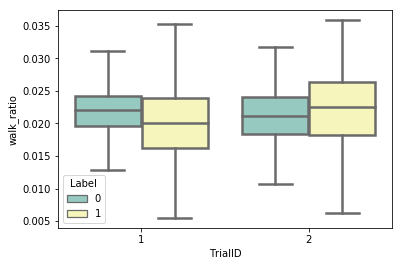

In [184]:
import seaborn as sns
sns.boxplot(x= 'TrialID', hue = 'Label', y='walk_ratio', data=raw_df, linewidth=2.5, palette="Set3", showfliers=False)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

X, y = raw_df[list(dict_mr.keys())], raw_df['Label']
normalized_X = X#preprocessing.scale(X)
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features=16, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=46, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
k = 10
kf = KFold(n_splits = k, shuffle = True)
pipeline = make_pipeline(clf)
cv_result = cross_val_score(pipeline, normalized_X, y, cv = kf, scoring = 'f1')
cv_result.mean()

0.9284387434964712

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
X, y = mr_scaled_features[list(dict_mr.keys())], mr_scaled_features['Label']
normalized_X = X#preprocessing.scale(X)
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features=16, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=46, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
k = 10
kf = KFold(n_splits = k, shuffle = True)
pipeline = make_pipeline(clf)
cv_result = cross_val_score(pipeline, normalized_X, y, cv = kf, scoring = 'f1')
cv_result.mean()

0.8752282009043263